# Summarise and plot the perpixel phenometrics

In this notebook we plot the long-term average phenology across Australia, the long-term trends, and a number of plots that show the phenology time-series across Australia to show examples of change.

In [1]:
import os
import sys
import xvec
import pickle
import textwrap
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords
%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open per pixel phenology data

In [2]:
p_average = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/mean_phenology_perpixel.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/trends_phenology_perpixel.nc'), crs='EPSG:4326')

gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson')

## Per pixel plots

### Average phenology

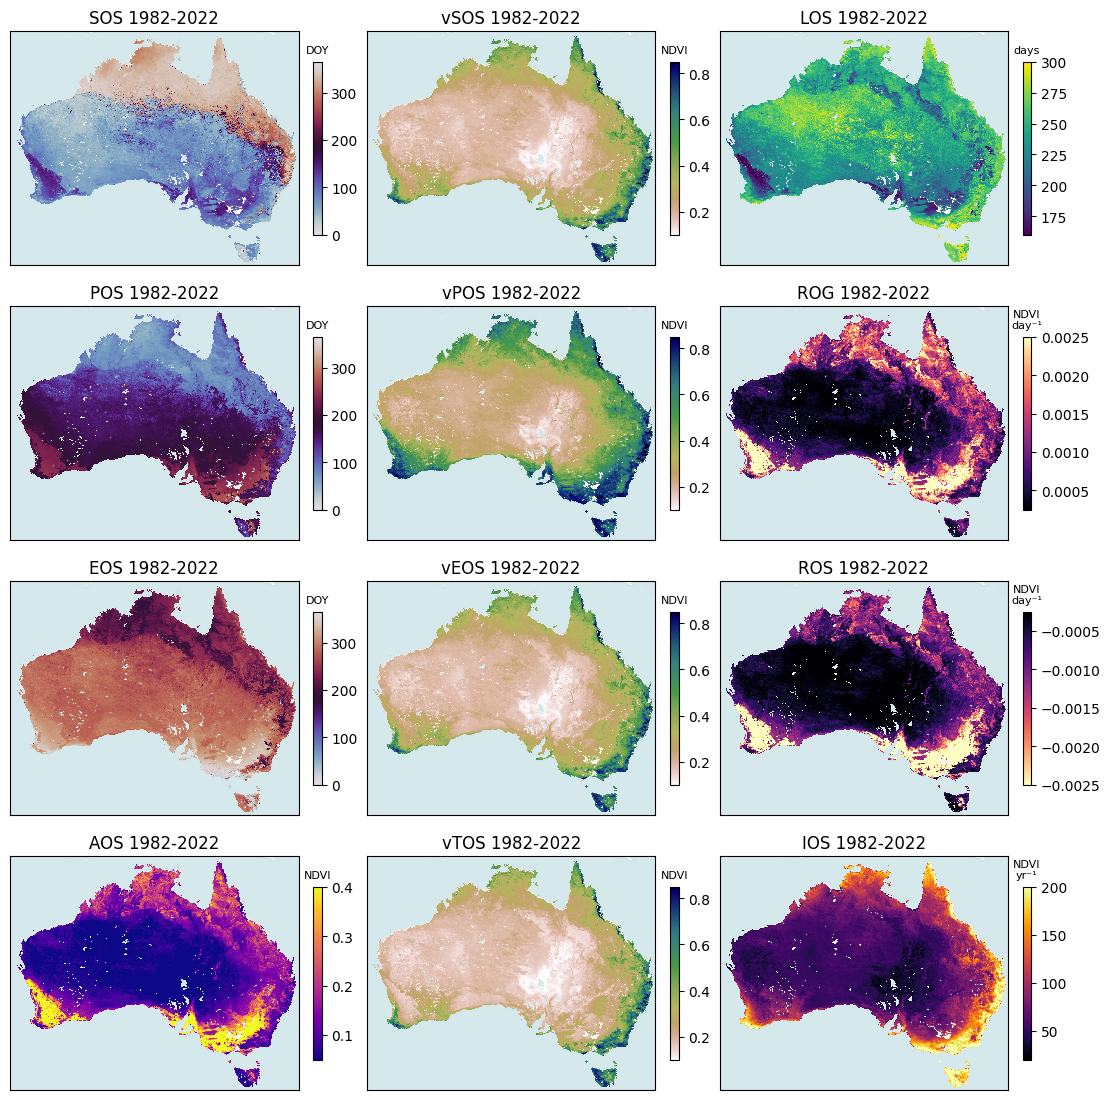

In [5]:
fig,axes=plt.subplots(4,3, figsize=(11,11), sharey=True, sharex=True, layout='constrained')

pheno_stats=[
    'SOS','vSOS', 'LOS', 
    'POS', 'vPOS', 'ROG',
    'EOS', 'vEOS', 'ROS',
    'AOS', 'vTOS', 'IOS'
]

cmaps = ['twilight', 'gist_earth_r', 'viridis',
         'twilight', 'gist_earth_r','magma',
         'twilight', 'gist_earth_r', 'magma_r',
         'plasma', 'gist_earth_r', 'inferno'
        ]
for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):
    if "v" not in pheno:
        vmin, vmax=0, 365
        label='DOY'
    if "v" in pheno:
        vmin,vmax=0.1, 0.85
        label='NDVI'
    if 'LOS' in pheno:
        vmin, vmax=160, 300
        label='days'
    if 'AOS' in pheno:
        vmin, vmax=0.05, 0.4
        label='NDVI'
    if 'IOS' in pheno:
        vmin, vmax=20, 200
        label='NDVI\nyr⁻¹'
    if 'ROG' in pheno:
        vmin, vmax=0.00025, 0.0025
        label='NDVI\nday⁻¹'
    if 'ROS' in pheno:
        vmin, vmax=-0.0025, -0.00025
        label='NDVI\nday⁻¹'
    im=p_average[pheno].plot(ax=ax, add_colorbar=False, cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    #need to create colorbar manually to have label on top
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
    ax_cbar.ax.set_title(label, fontsize=8)
    ax.set_title(f'{pheno} 1982-2022')

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/average_phenometrics_perpixel_AusENDVI.png',
            bbox_inches='tight', dpi=300)

### Plot number of seasons

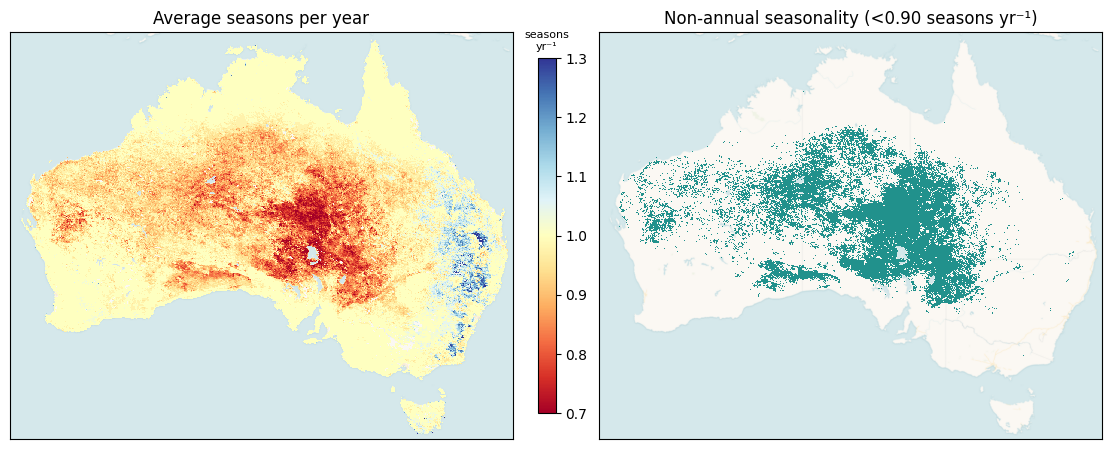

In [4]:
vmin,vmax=33,45
vmin,vmax=0.7,1.3
cmap='RdYlBu'
fig,ax=plt.subplots(1,2, figsize=(11,6), layout='constrained')
(p_average['n_seasons']/39).plot(add_colorbar=False, add_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, ax=ax[0])
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])

#need to create colorbar manually to have label on top
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
ax_cbar = fig.colorbar(cbar, ax=ax[0], shrink=0.6)
ax_cbar.ax.set_title('seasons\nyr⁻¹', fontsize=8)
ax[0].set_title('Average seasons per year');

# non_seasonal = xr.where((p_average['n_seasons']>42) | (p_average['n_seasons']<36),1,0)
non_seasonal = xr.where((p_average['n_seasons']/39 < 0.90),1,0)
non_seasonal.where(non_seasonal==1).plot(add_colorbar=False, add_labels=False,ax=ax[1])
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_title('Non-annual seasonality (<0.90 seasons yr⁻¹)');

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/num_seasons_AusENDVI-clim_MCD43A4.png',
            bbox_inches='tight', dpi=300);


### Phenology trends

This is inordinately slow owing to the significance hatch plotting.

In [5]:
#mask irrigated cropping regions
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==2, 0, 1) #irrigated crops
crops = round_coords(crops)

p_trends = p_trends.where(crops)

In [ ]:
fig,axes=plt.subplots(4,3, figsize=(11,11),  layout='constrained')#sharey=True, sharex=True,
pheno_stats=['SOS','vSOS', 'LOS', 
             'POS', 'vPOS', 'ROG',
             'EOS', 'vEOS', 'ROS',
             'AOS', 'vTOS', 'IOS'
      ]
cmaps = ['coolwarm','BrBG','PRGn',
         'coolwarm','BrBG','Spectral',
         'coolwarm','BrBG','Spectral_r',
         'PiYG','BrBG','PuOr'
        ]
for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):
   
    if "v" not in pheno:
        vmin, vmax=-2.0,2.0
        label='days\nyr⁻¹'
    if "v" in pheno:
        vmin,vmax=-0.0025, 0.0025
        label='NDVI\nyr⁻¹'
    if 'LOS' in pheno:
        vmin, vmax=-2.0, 2.0
        label='days\nyr⁻¹'
    if 'AOS' in pheno:
        vmin, vmax=-0.0025, 0.0025
        label='NDVI\nyr⁻¹'
    if 'ROG' in pheno:
        vmin, vmax=-2.5e-05, 2.5e-05
        label='NDVI\nday⁻¹ yr⁻¹'
    if 'ROS' in pheno:
        vmin, vmax=-2.5e-05, 2.5e-05
        label='NDVI\nday⁻¹ yr⁻¹'
    if 'IOS' in pheno:
        vmin, vmax=-1, 1
        label='NDVI\nyr⁻¹'

    d_to_plot = p_trends[pheno+'_slope']    
    im=d_to_plot.plot(ax=ax, add_colorbar=False, cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False)
                             
    # significance plotting
    lons, lats = np.meshgrid(d_to_plot.longitude, d_to_plot.latitude)
    sig_area = np.where(p_trends[pheno+'_p_value'] <= 0.05)
    ax.hexbin(x=lons[sig_area].reshape(-1),
             y=lats[sig_area].reshape(-1),
             C=d_to_plot.where(p_trends[pheno+'_p_value'] <= 0.05).data[sig_area].reshape(-1),
             hatch='....',
             alpha=0,
             gridsize=(400,400)
            )    

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    #need to create colorbar manually to have label on top
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
    ax_cbar.ax.set_title(label, fontsize=8)
    ax.set_title(f'{pheno} trend')
    # print(pheno)
    
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/Trends_phenometrics_perpixel_AusENDVI.png',
            bbox_inches='tight', dpi=300)

Error in callback <function _draw_all_if_interactive at 0x147d7341ce50> (for post_execute), with arguments args (),kwargs {}:

## Facet plots of phenograms

For a selection of IBRA subregions, show phenograms.

In [ ]:
# gdf.explore(column='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#             control = True,
#             legend=False
#            )

Error in callback <function flush_figures at 0x147d68462a70> (for post_execute), with arguments args (),kwargs {}:


In [55]:
product='AusENDVI-clim_MCD43A4'
timeseries_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_NDVI_AusENDVI-clim_MCD43A4.pkl'
with open(timeseries_file, 'rb') as f:
    results = pickle.load(f)

#open a simple landcover map
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/NVISv6_simplified_5km.nc')
mask = ~np.isnan(p_trends.vPOS_slope)
lc = lc.where(mask)

crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = round_coords(crops)
rainfed_crops = xr.where(crops!=3, 0, 1) 
irrigated_crops = xr.where(crops!=2, 1, 0) 

lc = lc.where(irrigated_crops) #mask irrigated
lc = xr.where(rainfed_crops==1,5,lc) #add rainfed cropping as a class


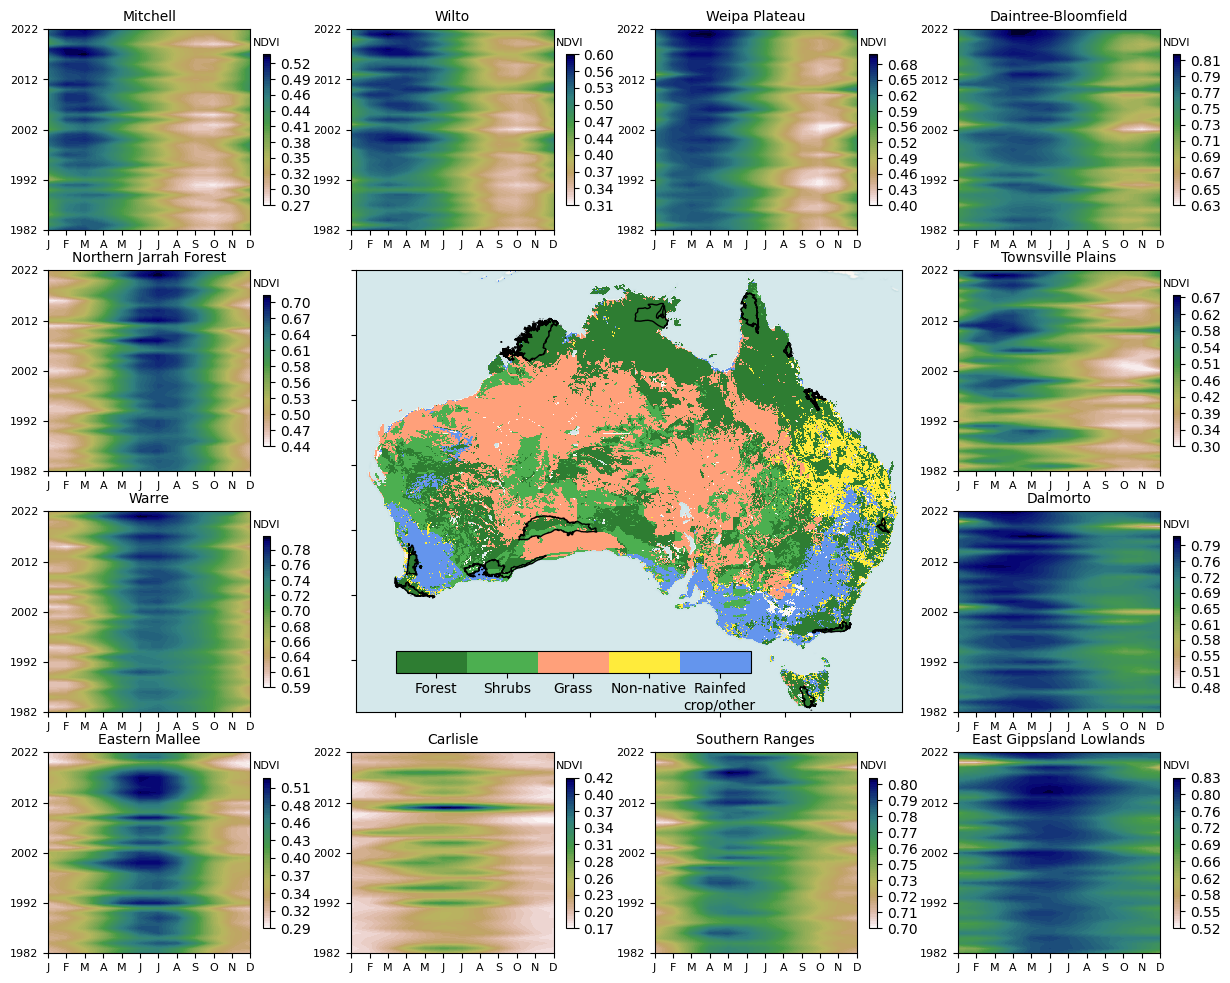

In [56]:
layout = [
    ['A',  'B',    'C', 'D'],
    ['E','center', 'center', 'F'],
    ['G','center', 'center', 'H'],
    ['I',  'J',    'K', 'L']
]

locs =[
    'Mitchell','Wilto', 'Weipa Plateau','Daintree-Bloomfield', #Birdum ''
    'Northern Jarrah Forest', 'Townsville Plains', #''
    'Warre', 'Dalmorto',  #'Southern Jarrah Forest'
    'Eastern Mallee','Carlisle','Southern Ranges','East Gippsland Lowlands'
      ] # '

# Create the mosaic plot
fig, axes = plt.subplot_mosaic(layout, figsize=(15, 12))

subax=[
    axes['A'], axes['B'],axes['C'],axes['D'],
    axes['E'],axes['F'],axes['G'], axes['H'],
    axes['I'],axes['J'],axes['K'], axes['L']
      ]

#centre image of basic landcover
colors = ['#2E7D32','#4CAF50', 'lightsalmon', '#FFEB3B', 'cornflowerblue'] #Forest,Shrub, GRass, non-natie, rainfed cropping
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colors, N=len(colors))
im = lc.plot(cmap=cmap, ax=axes['center'], add_colorbar=False, add_labels=False)
gdf[gdf['SUB_NAME_7'].isin(locs)].plot(ax=axes['center'], color=None, facecolor="none", edgecolor='k',linewidth=1)

axins1 = inset_axes(axes['center'],width="65%",height="5%",loc="lower left", borderpad=2.85)
cbar = fig.colorbar(im,cax=axins1, ticks=[1.45,2.25,3,3.85,4.65],orientation='horizontal')
cbar.ax.set_xticklabels(['Forest', 'Shrubs', 'Grass', 'Non-native', 'Rainfed\ncrop/other'])

ctx.add_basemap(axes['center'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
axes['center'].set_yticklabels([])
axes['center'].set_xticklabels([])
axes['center'].set_title(None)

#create a grid
xi = np.linspace(1, 12, 12) #months
yi = np.linspace(1982, 2022, 41) #years
Xi, Yi = np.meshgrid(xi, yi) #grid coords

for ax,k,v in zip(subax, locs, [results[x] for x in locs]):
    dss = v.resample(time='MS').mean()
    zi = griddata(points=(dss.time.dt.month, dss.time.dt.year),
                  values=dss.values,
                  xi=(xi[None, :], yi[:, None]),
                  method='nearest')
    
    sp = ax.contourf(zi, levels=75, cmap='gist_earth_r')
    clb = fig.colorbar(sp, ax=ax, shrink=0.75, format="%0.2f")
    clb.ax.set_title('NDVI', fontsize=8)
    ax.set(xticks=range(0,12))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=8);
    ax.set(yticks=range(0,41))
    ax.set_yticklabels([str(y) for y in range(1982,2023)], fontsize=8);
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10))
    ax.set_title(k, fontsize=10);

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/phenograms_headlinefigure.png',
          bbox_inches='tight', dpi=300);

## Example phenology timeseries for some regions

In [57]:
phenometrics_file = '/g/data/os22/chad_tmp/Aus_phenology/data/pickle/IBRA_subregions_AusENDVI-clim_MCD43A4_phenometrics.pkl'
with open(phenometrics_file, 'rb') as f:
    eco_regions_phenometrics = pickle.load(f)

/jobfs/126568199.gadi-pbs/ipykernel_793116/497483186.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:2.2f}'.format(x) for x in ax.get_yticks()])
/jobfs/126568199.gadi-pbs/ipykernel_793116/497483186.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:2.2f}'.format(x) for x in ax.get_yticks()])
/jobfs/126568199.gadi-pbs/ipykernel_793116/497483186.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:2.2f}'.format(x) for x in ax.get_yticks()])
/jobfs/126568199.gadi-pbs/ipykernel_793116/497483186.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:2.2f}'.format(x)

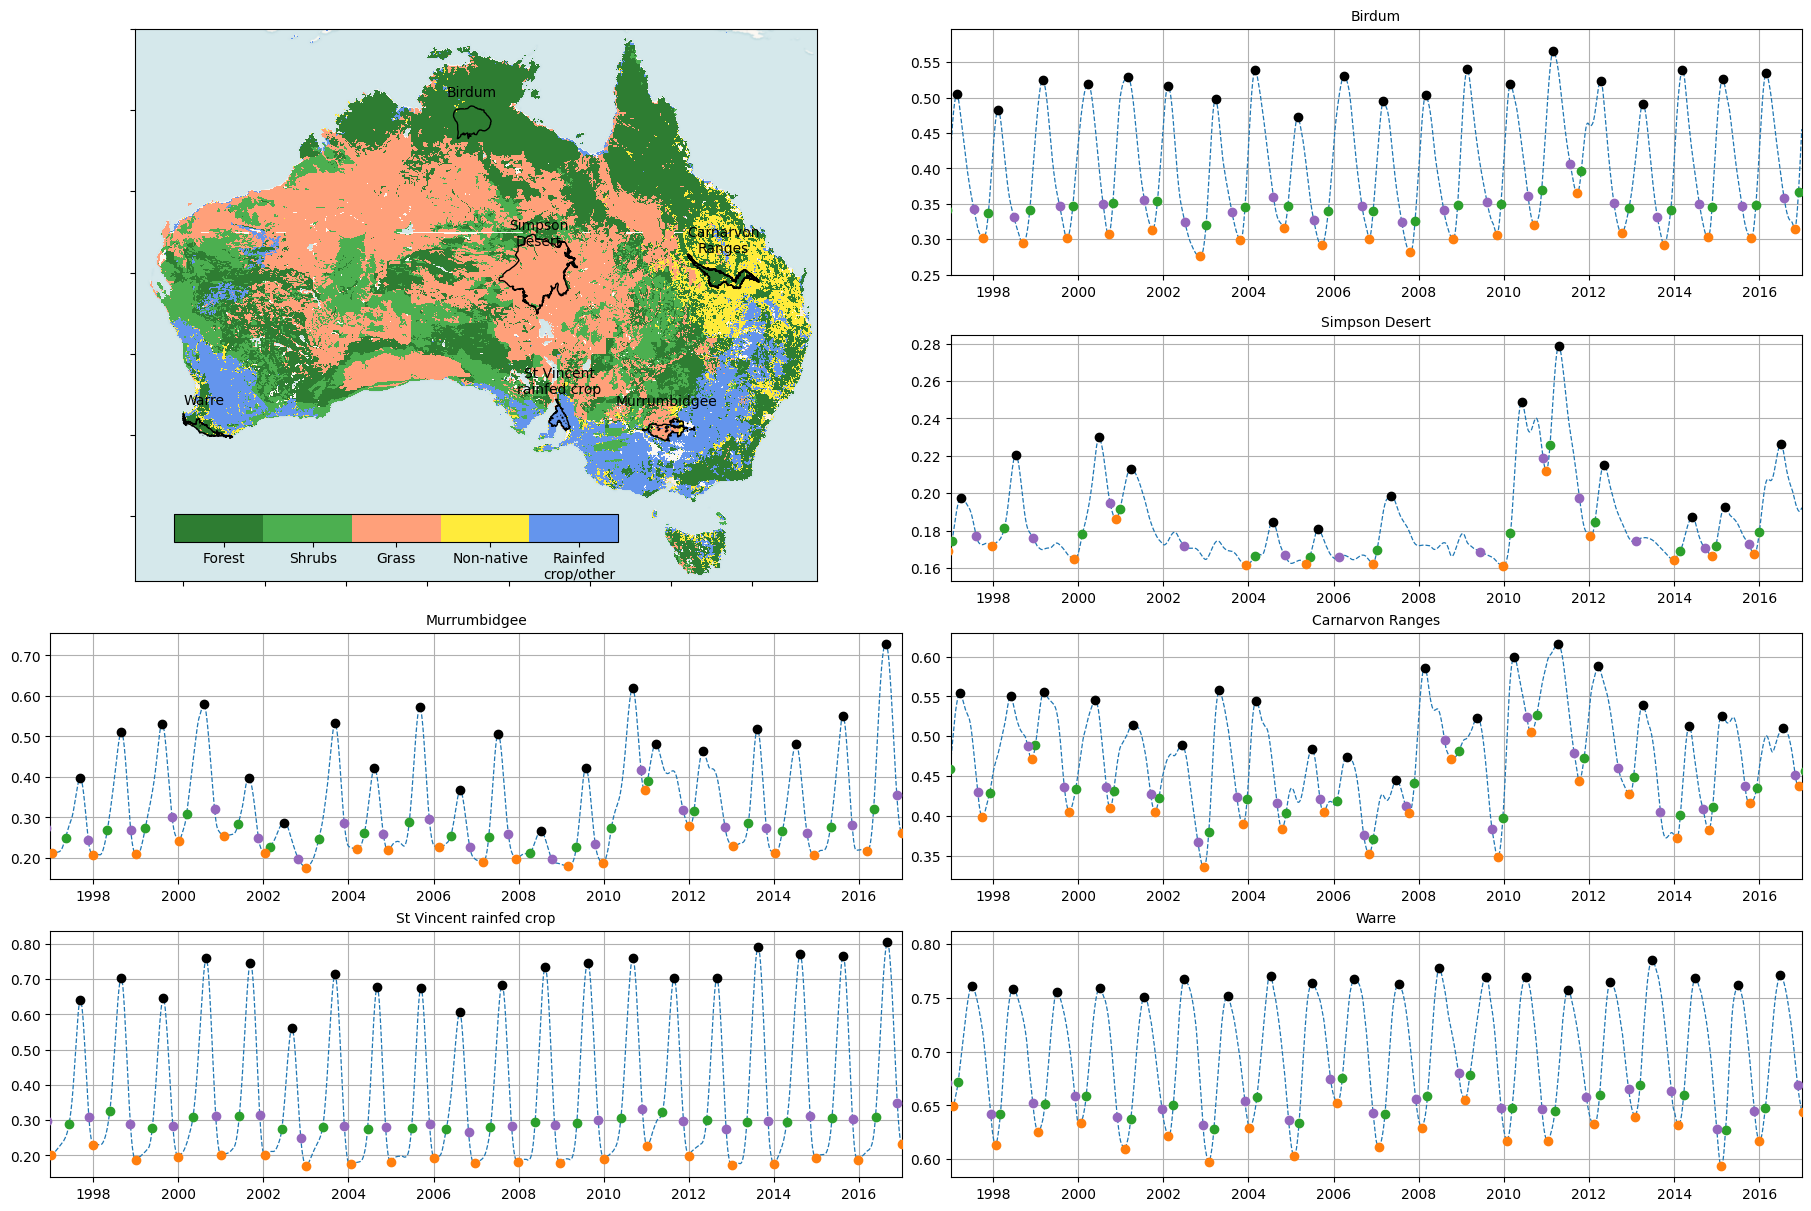

In [58]:
layout = [
    ['A','A','A', 'B', 'B','B'],
    ['A','A','A', 'C', 'C','C'],
    ['D','D', 'D', 'E', 'E','E'],
    ['F',  'F','F', 'G', 'G', 'G']
]

locs =[
    'Birdum','Simpson Desert', 'Murrumbidgee',
    'Carnarvon Ranges', 'St Vincent rainfed crop', 'Warre'
      ]

# Create the mosaic plot
# with plt.style.context('ggplot'):
fig, axes = plt.subplot_mosaic(layout, figsize=(18, 12), layout='constrained')

subax=[
    axes['B'],axes['C'],axes['D'],
    axes['E'],axes['F'], axes['G']
      ]

#image of basic landcover
colors = ['#2E7D32','#4CAF50', 'lightsalmon', '#FFEB3B', 'cornflowerblue'] #Forest,Shrub, GRass, non-natie, rainfed cropping
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colors, N=len(colors))
im = lc.plot(cmap=cmap, ax=axes['A'], add_colorbar=False, add_labels=False)
gdf[gdf['SUB_NAME_7'].isin(locs)].plot(ax=axes['A'], color=None, facecolor="none", edgecolor='k',linewidth=1)

axins1 = inset_axes(axes['A'],width="65%",height="5%",loc="lower left", borderpad=2.85)
cbar = fig.colorbar(im,cax=axins1, ticks=[1.45,2.25,3,3.85,4.65],orientation='horizontal')
cbar.ax.set_xticklabels(['Forest', 'Shrubs', 'Grass', 'Non-native', 'Rainfed\ncrop/other'])

ctx.add_basemap(axes['A'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
axes['A'].set_yticklabels([])
axes['A'].set_xticklabels([])
axes['A'].set_title(None)

# label polygons
gdf[gdf['SUB_NAME_7'].isin(locs)].apply(lambda x: axes['A'].annotate(text=textwrap.fill(x['SUB_NAME_7'], 12),
                        xy=x.geometry.centroid.coords[0], 
                        xytext=(x.geometry.centroid.coords[0][0], x.geometry.centroid.coords[0][1]+1.5),
                        ha='center', fontsize=10), axis=1)

ctx.add_basemap(axes['A'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
axes['A'].set_yticklabels([])
axes['A'].set_xticklabels([])
axes['A'].set_title(None)

for ax,k,v in zip(subax, locs, [results[x] for x in locs]):
    v.plot(ax=ax, color='tab:blue', linestyle='--', linewidth=0.9, label='Daily NDVI') #.sel(time=slice('1997','2016'))
    # ax.set_ylim(0.15, 0.7)
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].SOS.values, eco_regions_phenometrics[k].SOS_year.values)],
               y=eco_regions_phenometrics[k].vSOS,
              c='tab:green', label='SOS', zorder=10)
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].EOS.values, eco_regions_phenometrics[k].EOS_year.values)],
               y=eco_regions_phenometrics[k].vEOS,
              c='tab:purple', label='EOS', zorder=10)
    
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].POS.values, eco_regions_phenometrics[k].POS_year.values)],
                   y=eco_regions_phenometrics[k].vPOS,
                  c='black', label='POS', zorder=10)
        
    ax.scatter(x=[pd.to_datetime(d-1, unit='D', origin=str(int(y))) for d,y in zip(eco_regions_phenometrics[k].TOS.values, eco_regions_phenometrics[k].TOS_year.values)],
               y=eco_regions_phenometrics[k].vTOS,
              c='tab:orange', label='TOS', zorder=10)
    
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_title(k, fontsize=10)
    ax.grid()
    ax.set_yticklabels(['{:2.2f}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(pd.Timestamp("1997-01-1"), pd.Timestamp("2016-12-31"))
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/phenology_example_regions.png',
      bbox_inches='tight', dpi=300);

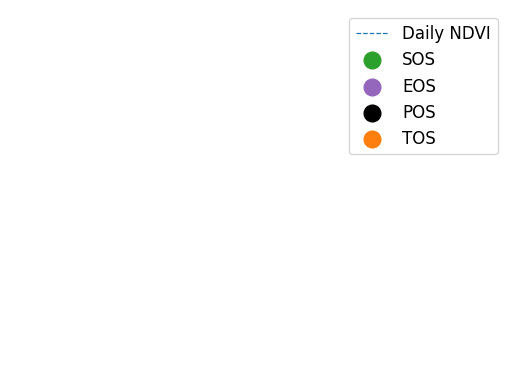

In [59]:
# get handles and labels for reuse
label_params = axes['G'].get_legend_handles_labels() 

figl, axl = plt.subplots()
axl.axis(False)
axl.legend(*label_params, loc="best", fontsize=12, markerscale=2, ncol=1)
figl.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/legend_example_phenology.png',
          bbox_inches='tight', dpi=300);

## Consistency of direction in SOS and EOS trends 

Make a map that shows if SOS and EOS are trending in the same direction, or are instead diverging. This will show why LOS is shifting (or not).

## Summarise over IBRA polygons

In [ ]:
# ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
# gdf = gpd.read_file(ecoregions_file)

# p_average_gdf = p_average.xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude", stats="mean"
# ).xvec.to_geodataframe()

# p_trends_gdf = p_trends.xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude", stats="mean"
# ).xvec.to_geodataframe()

In [ ]:
# fig,axes=plt.subplots(4,3, figsize=(11,11), sharey=True, sharex=True, layout='constrained')
# pheno_stats=['SOS','vSOS', 'LOS', 
#              'POS', 'vPOS', 'ROG',
#              'EOS', 'vEOS', 'ROS',
#              'IOS', 'vTOS', 'AOS',
#       ]
# cmaps = ['twilight', 'gist_earth_r', 'viridis',
#          'twilight', 'gist_earth_r','magma',
#          'twilight', 'gist_earth_r', 'magma_r',
#          'inferno', 'gist_earth_r','plasma'
#         ]
# for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):
#     if "v" not in pheno:
#         vmin, vmax=0, 365
#         label='DOY'
#     if "v" in pheno:
#         vmin,vmax=0.1, 0.85
#         label='NDVI'
#     if 'LOS' in pheno:
#         vmin, vmax=160, 300
#         label='days'
#     if 'AOS' in pheno:
#         vmin, vmax=0.05, 0.4
#         label='NDVI'
#     if 'IOS' in pheno:
#         vmin, vmax=20, 200
#         label='NDVI/\n season'
#     if 'ROG' in pheno:
#         vmin, vmax=0.00025, 0.0025
#         label='NDVI/\nday'
#     if 'ROS' in pheno:
#         vmin, vmax=-0.0025, -0.00025
#         label='NDVI/\nday'
#     im=p_average_gdf.plot(column=pheno, ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)
#     ctx.add_basemap(im, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
#     #need to create colorbar manually to have label on top
#     norm = colors.Normalize(vmin=vmin, vmax=vmax)
#     cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#     ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
#     ax_cbar.ax.set_title(label, fontsize=8)
#     ax.set_title(f'{pheno}, 1982-2022')

# fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/average_phenometrics_map_IBRA_AusENDVI-clim_MCD43A4.png',
#             bbox_inches='tight', dpi=300)

### Plot summarised trends

In [ ]:
# fig,axes=plt.subplots(4,3, figsize=(11,11),  layout='constrained')#sharey=True, sharex=True,
# pheno_stats=['SOS','vSOS', 'LOS', 
#              'POS', 'vPOS', 'ROG',
#              'EOS', 'vEOS', 'ROS',
#              'AOS', 'vTOS', 'IOS'
#       ]
# cmaps = ['coolwarm','BrBG','PRGn',
#          'coolwarm','BrBG','Spectral',
#          'coolwarm','BrBG','Spectral_r',
#          'PiYG','BrBG','PuOr'
#         ]

# for ax,pheno,cmap in zip(axes.ravel(), pheno_stats, cmaps):
   
#     if "v" not in pheno:
#         vmin, vmax=-1.5,1.5
#         label='days/\nyear'
#     if "v" in pheno:
#         vmin,vmax=-0.0015, 0.0015
#         label='NDVI/\nyear'
#     if 'LOS' in pheno:
#         vmin, vmax=-1.5, 1.5
#         label='days/\nyear'
#     if 'AOS' in pheno:
#         vmin, vmax=-0.002, 0.002
#         label='NDVI\nyear'
#     if 'ROG' in pheno:
#         vmin, vmax=-2.0e-05, 2.0e-05
#         label='NDVI/day/\nyear'
#     if 'ROS' in pheno:
#         vmin, vmax=-2.0e-05, 2.0e-05
#         label='NDVI/day/\nyear'
#     if 'IOS' in pheno:
#         vmin, vmax=-0.5, 0.5
#         label='NDVI/\nyear'

#     # im=pheno_trends.plot(column=pheno+'_slope', ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)
    
#     significant = p_trends_gdf[p_trends_gdf[pheno+'_p_value'] <= 0.1]
#     not_significant = p_trends_gdf[p_trends_gdf[pheno+'_p_value'] > 0.1]
    
#     im=significant.plot(column=pheno+'_slope', ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax, hatch='....')     
#     not_significant.plot(column=pheno+'_slope', ax=ax, legend=False, cmap=cmap, vmin=vmin, vmax=vmax)     

#     ctx.add_basemap(im, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
#     ax.axes.get_xaxis().set_ticks([])
#     ax.axes.get_yaxis().set_ticks([])
    
#     #need to create colorbar manually to have label on top
#     norm = colors.Normalize(vmin=vmin, vmax=vmax)
#     cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#     ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
#     ax_cbar.ax.set_title(label, fontsize=8)
#     ax.set_title(f'{pheno}, 1982-2022')
#     print(pheno)
    
# # axes[3,2].axis('off');
# fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/trends_phenometrics_map_IBRA_AusENDVI-clim_MCD43A4.png',
#             bbox_inches='tight', dpi=300)